# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'Neural Point Process

In [53]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from skimage import io, transform
from functools import lru_cache
from tools.plot_utils import visualize_pins, plot_label_pin, plot_all, plot_and_save, plot_loss
from tools.data_utils import *
from tools.losses import NPPLoss
from tools.models import Autoencoder
from tools.optimization import EarlyStoppingCallback, train_model, evaluate_model
import matplotlib.pyplot as plt
import time
from tools.models import *

In [55]:
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy
# Set matplotlib and seaborn plotting style
sns.set_style('darkgrid')

In [56]:
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [57]:
# Gaussian process posterior
def GP(X1, y1, mu1, X2, mu2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Cov11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Cov12 = kernel_func(X1, X2)
    # Solve
    print(Cov11.shape, Cov12.shape)
    solved = scipy.linalg.solve(Cov11, Cov12, assume_a='pos').T
    # Compute posterior mean
    print("mu", (solved @ (y1-mu1)).shape, solved.shape, (y1-mu1).shape, mu2.shape)
    mu2_new = solved @ (y1-mu1)+mu2
    
    # Compute the posterior covariance
    Cov22 = kernel_func(X2, X2)
    Cov22_new = Cov22 - (solved @ Cov12)
    print("cov", Cov22.shape, (solved @ Cov12).shape)
    return mu2_new, Cov22_new  # mean, covariance

In [58]:
X1.shape, X2.shape

((8, 2), (75, 2))

In [59]:
n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)
dim=2

if dim==1:
    # Define the true function that we want to regress on
    f_sin = lambda x: (np.sin(x)).flatten()
else:
    def f_sin(X):
        beta = np.array([1, 0.5])  # Coefficient vector for dot product
        return np.sin(X @ beta)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, dim))

y1 = f_sin(X1)

if dim==1:
    # Predict points at uniform spacing to capture function
    X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
else:
    X2 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n2, dim))

mu1, mu2 = np.zeros(n1), np.zeros(n2)
# Compute posterior mean and covariance
mu2, cov2 = GP(X1, y1, mu1, X2, mu2, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
sigma2 = np.sqrt(np.diag(cov2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=mu2, cov=cov2, size=ny)

(8, 8) (8, 75)
mu (75,) (75, 8) (8,) (75,)
cov (75, 75) (75, 75)


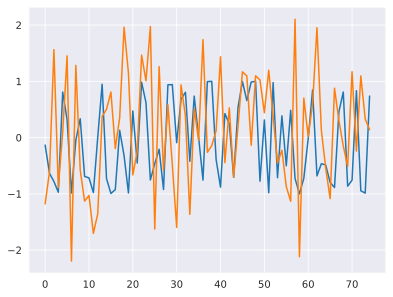

In [69]:
plt.plot(f_sin(X2))
plt.plot((y2)[0])

In [65]:
y2.shape

(5, 75)

ValueError: operands could not be broadcast together with shapes (150,) (75,) 

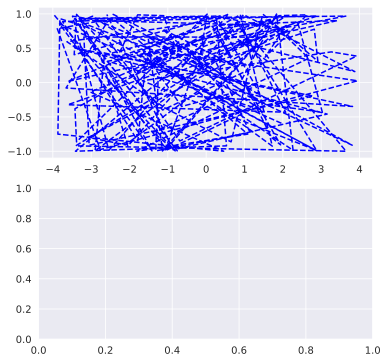

In [52]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, mu2-2*sigma2, mu2+2*sigma2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, mu2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()

# Dataset and Visualization

In [4]:
# Set a random seed for PyTorch
seed = 4  # You can use any integer value as the seed
torch.manual_seed(seed)
# Set a random seed for NumPy (if you're using NumPy operations)
np.random.seed(seed)

In [5]:
dataset = "PinMNIST"
feature_extracted = True
n = 500
mesh = False
d = 10
n_pins = 20
fixed_pins = True
r = 3
d1,d2 = 28,28
if feature_extracted:
    folder = f"{dataset}_ddpm"
else:
    folder = f"{dataset}"

if dataset == "PinMNIST":
    if mesh:
        data_folder = f"./data/{folder}/{n}images_mesh_{d}step_{28}by{28}pixels_{r}radius_{seed}seed"
    else:
        data_folder = f"./data/{folder}/{n}images_random_fixed{fixed_pins}_{n_pins}pins_{28}by{28}pixels_{r}radius_{seed}seed"

if dataset == "Synthetic":
    if mesh:
        data_folder = f"./data/{folder}/{n}images_{d1}by{d2}pixels_{d}_distanced_grid_pins_{seed}seed/"
    else:
        data_folder = f"./data/{folder}/{n}images_{d1}by{d2}pixels_upto{n_pins}pins_{seed}seed/"
        
    
    
# data_folder = f"./data/MNIST_{n}images_mesh_{d}step_{28}by{28}pixels_{r}radius_{seed}seed"
# data_folder = "./data/Synthetic_100images_32by32pixels_upto500pins_4seed"

In [6]:
# Create a transform pipeline that includes the resizing step
# if dataset == "PinMNIST":

transform = transforms.Compose([
    ToTensor(),         # Convert to tensor (as you were doing)
    Resize()  # Resize to 100x100
])

transformed_dataset = PinDataset(csv_file=f"{data_folder}/pins.csv",
                                      root_dir=f"{data_folder}/images/",
                                      transform=transform)

dataset_size = len(transformed_dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    transformed_dataset, [train_size, val_size, test_size]
)

# Define batch size
batch_size = 64

def custom_collate_fn(batch):
    images = [sample['image'] for sample in batch]
    pins = [sample['pins'] for sample in batch]
    outputs = [sample['outputs'] for sample in batch]

    return {
        'image': torch.stack(images, dim=0),
        'pins': pins,
        'outputs': outputs}

# Create your DataLoader with the custom_collate_fn
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

In [7]:
for batch in train_loader:
    images = batch['image'] # get RGB instead of RGBA
    pins = batch['pins']
    outputs = batch['outputs']

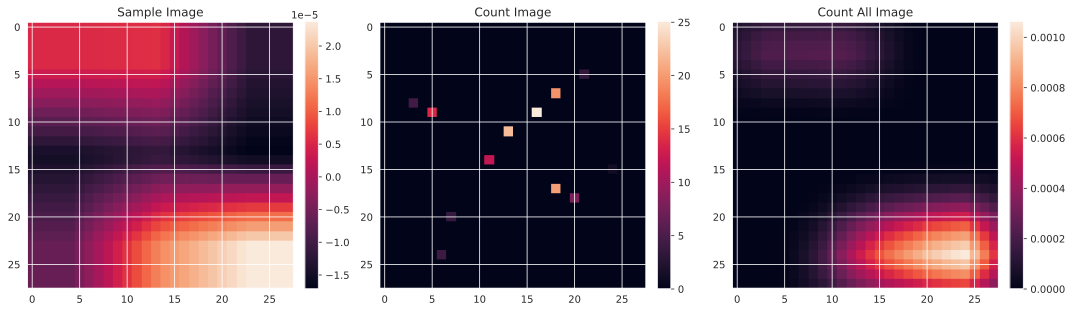

In [8]:
sample_img = images[0][0].squeeze().detach().cpu()/255
count_image = plot_label_pin(sample_img, pins[0], outputs[0])
count_all_image = plot_all(sample_img, r=3)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the sample_img in the first subplot
im0 = axes[0].imshow(sample_img)
axes[0].set_title('Sample Image')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)  # Add colorbar

# Plot the count_image in the second subplot
im1 = axes[1].imshow(count_image)
axes[1].set_title('Count Image')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)  # Add colorbar

# Plot the count_all_image in the third subplot
im2 = axes[2].imshow(count_all_image)
axes[2].set_title('Count All Image')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)  # Add colorbar

# Add spacing between subplots
plt.tight_layout()
# Display the figure
plt.show()

# Training

In [9]:
class CustomLRFinder:
    def __init__(self, model, criterion, optimizer, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.history = {'lr': [], 'loss': []}

    def find_lr(self, train_loader, start_lr=1e-4, end_lr=1, num_iter=10,smooth_f=0.05):
        model = self.model.to(self.device)
        criterion = self.criterion
        optimizer = self.optimizer
        device = self.device
        model.train()

        lr_step = (end_lr / start_lr) ** (1 / num_iter)
        lr = start_lr

        for iteration in range(num_iter):
            optimizer.param_groups[0]['lr'] = lr

            total_loss = 0.0
            for batch in train_loader:
                x_train = batch['image'][:, :input_channel, :, :].to(device)
                p_train = [tensor.to(device) for tensor in batch['pins']]
                y_train = [tensor.to(device) for tensor in batch['outputs']]

                optimizer.zero_grad()
                outputs = model(x_train.float())
                loss = criterion(y_train, outputs, p_train)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            self.history['lr'].append(lr)
            self.history['loss'].append(avg_loss)

            lr *= lr_step
            
    def plot_lr_finder(self):
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')  # Use a logarithmic scale for better visualization
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Finder Curve')
        plt.show()
        
    def find_best_lr(self, skip_start=3, skip_end=3):
        # Find the index of the minimum loss in the specified range
        min_loss_index = skip_start + np.argmin(self.history['loss'][skip_start:-skip_end])

        # Output the learning rate corresponding to the minimum loss
        best_lr = self.history['lr'][min_loss_index]
        return best_lr

Best Learning Rate for MSE: 0.005623413251903489
Best Learning Rate for NPP sigma=0.1: 0.0039810717055349725
Best Learning Rate for NPP sigma=0.2: 0.0039810717055349725
Best Learning Rate for NPP sigma=0.5: 0.0015848931924611134
Best Learning Rate for NPP sigma=1: 0.0015848931924611134
Best Learning Rate for NPP sigma=2: 0.0251188643150958


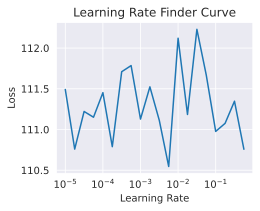

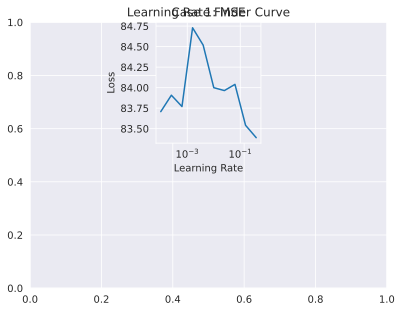

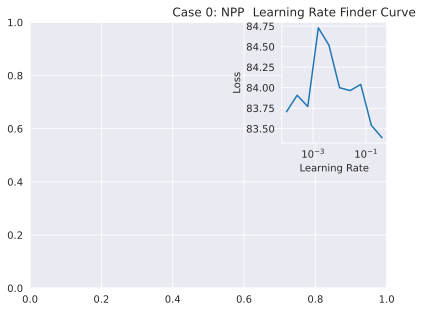

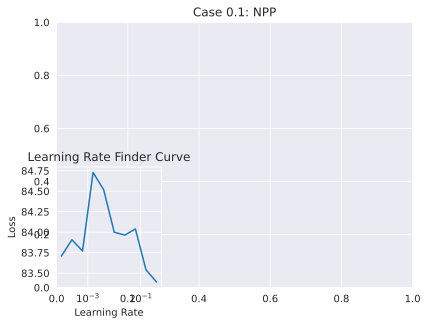

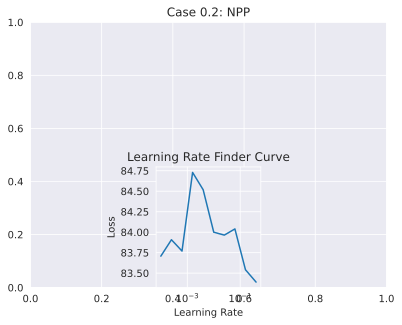

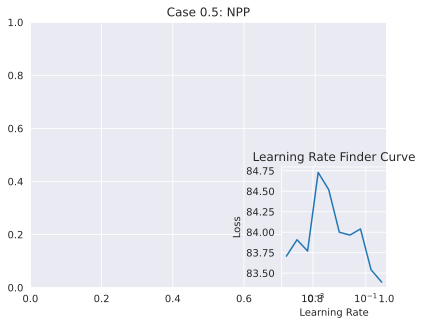

ValueError: num must be an integer with 1 <= num <= 6, not 7

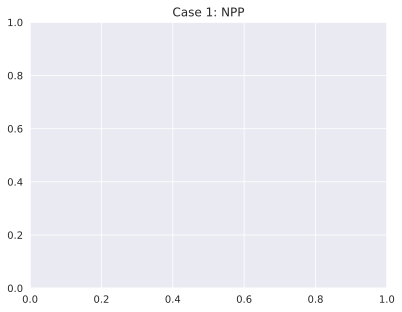

In [10]:
# Case 1: identity=True
# Set your hyperparameters
input_channel = 1 if dataset == "PinMNIST" else 3
num_epochs = 200
sigmas = [0.1, 0.2, 0.5, 1, 2, 5]  # Set the sigma values you want to test
num_kernels_encoder = [32, 16]
num_kernels_decoder = [32]
learning_rate = 0.01
val_every_epoch = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


criterion_MSE = NPPLoss(identity=True).to(device)
lr_finder_MSE = CustomLRFinder(model, criterion_MSE, optimizer, device=device)
lr_finder_MSE.find_lr(train_loader, start_lr=1e-5, end_lr=1, num_iter=20)
best_lr_MSE = lr_finder_MSE.find_best_lr()
print(f"Best Learning Rate for MSE: {best_lr_MSE}")


# Cases 2-6: identity=False, varying sigmas
best_lrs = [(0,best_lr_MSE)]

sigmas = [0.1, 0.2, 0.5, 1, 2]

for sigma in sigmas:
    criterion_NPP = NPPLoss(identity=False, sigma=sigma).to(device)
    lr_finder_NPP = CustomLRFinder(model, criterion_NPP, optimizer, device=device)
    lr_finder_NPP.find_lr(train_loader, start_lr=1e-4, end_lr=1, num_iter=10)
    best_lr_NPP = lr_finder_NPP.find_best_lr()
    best_lrs.append((sigma, best_lr_NPP))
    print(f"Best Learning Rate for NPP sigma={sigma}: {best_lr_NPP}")

# Plot learning rate finder curves
plt.figure(figsize=(12, 6))

# Case 1
plt.subplot(2, 3, 1)
lr_finder_MSE.plot_lr_finder()
plt.title("Case 1: MSE")

# Cases 2-6
for i, (sigma, best_lr) in enumerate(best_lrs, start=2):
    plt.subplot(2, 3, i)
    lr_finder_NPP.plot_lr_finder()
    plt.title(f"Case {sigma}: NPP")

plt.tight_layout()
plt.show()

print(best_lrs)

# PinMNIST
# Best Learning Rate for case 1: 0.04786300923226393
# Best Learning Rate for case 0.1: 0.08317637711026726
# Best Learning Rate for case 0.2: 0.04786300923226393
# Best Learning Rate for case 0.5: 0.00144543977074593
# Best Learning Rate for case 1: 0.04786300923226393
# Best Learning Rate for case 2: 0.2089296130854044
# Best Learning Rate for case 5: 0.0036307805477010196
# Best Learning Rate for case 10: 0.057543993733715805


# Synthetic
# 16 8
# Best Learning Rate for MSE: 0.005623413251903489
# Best Learning Rate for NPP sigma=0.1: 0.01
# Best Learning Rate for NPP sigma=0.2: 0.01
# Best Learning Rate for NPP sigma=0.5: 0.0039810717055349725
# Best Learning Rate for NPP sigma=1: 0.0015848931924611134
# Best Learning Rate for NPP sigma=2: 0.0039810717055349725
# 32 16
# Best Learning Rate for MSE: 0.0003162277660168379
# Best Learning Rate for NPP sigma=0.1: 0.0015848931924611134
# Best Learning Rate for NPP sigma=0.2: 0.0015848931924611134
# Best Learning Rate for NPP sigma=0.5: 0.0039810717055349725
# Best Learning Rate for NPP sigma=1: 0.0015848931924611134
# Best Learning Rate for NPP sigma=2: 0.0015848931924611134

In [ ]:
def run_pipeline_ci(sigmas, num_kernels_encoder, num_kernels_decoder, train_loader, val_loader, test_loader, input_channel, num_epochs, val_every_epoch, learning_rates, device, num_runs=3):
    test_losses_npp_true = []
    test_losses_npp_false= []
    experiment_id = int(time.time())
    
    for run in range(num_runs):
        count = 0
        test_losses_vs_sigma_npp_true = []
        test_loss_npp_false = None

        # Run NPP=False once and collect the test loss
        early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.001)
        criterion = NPPLoss(identity=True).to(device)

        autoencoder = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
        
        optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rates[count])
        model, train_losses, val_losses = train_model(autoencoder, train_loader, val_loader, input_channel, num_epochs,\
                                                      val_every_epoch, learning_rates[count], criterion, optimizer, device, early_stopping, experiment_id)

        test_loss_npp_false = evaluate_model(autoencoder, test_loader, input_channel, device)
        print(f"MSE Test loss:{test_loss_npp_false:.3f}")
        test_losses_npp_false.append(test_loss_npp_false)
        
        count += 1
        # Run LR Finder for different sigma values
        for sigma in sigmas:
            early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.001)
            criterion = NPPLoss(identity=False, sigma=sigma).to(device)
            autoencoder = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
            optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rates[count])
            model, train_losses, val_losses = train_model(autoencoder, train_loader, val_loader, input_channel, num_epochs,\
                                                          val_every_epoch, learning_rates[count], criterion, optimizer, device, early_stopping, experiment_id)
            test_loss = evaluate_model(autoencoder, test_loader, input_channel, device)
            print(f"NPP sigma={sigma} Test loss:{test_loss:.3f}")
            test_losses_vs_sigma_npp_true.append(test_loss)
            count += 1

        test_losses_npp_true.append(test_losses_vs_sigma_npp_true)
    return test_losses_npp_true, test_losses_npp_false

    
# Function to run the pipeline and save data
def run_and_save_pipeline(sigmas, num_kernels_encoder, num_kernels_decoder, train_loader, val_loader, test_loader, input_channel, num_epochs, val_every_epoch, learning_rates, device):
    # Run the pipeline
    test_loss_npp_true, test_loss_npp_false= run_pipeline_ci(sigmas, num_kernels_encoder, num_kernels_decoder, train_loader, val_loader, test_loader, input_channel, num_epochs, val_every_epoch, learning_rates, device)
    print("start saving!")
    # Save the data
    save_loss(test_loss_npp_true, './history/test_loss_npp_true.npy')
    save_loss(test_loss_npp_false, './history/test_loss_npp_false.npy')
    print("saved")
    return test_loss_npp_true, test_loss_npp_false

In [ ]:
# sigmas = [0.1, 0.2, 0.5, 1, 2, 5]
# losses = {}

# # Add the loss for NPP=False to the dictionary
# losses['npp_false'] = NPPLoss(identity=True).to(device)

# # Add losses for NPP=True with different sigmas to the dictionary
# for sigma in sigmas:
#     loss_name = f'npp_true_sigma_{sigma}'
#     losses[loss_name] = NPPLoss(identity=False, sigma=sigma).to(device)

# model = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
# best_lrs = find_best_lr_multiple_losses(model, train_loader, losses)

In [ ]:
# Generate a unique experiment_id using a timestamp
  # Using timestamp as experiment_id

# Set your hyperparameters
# dataset = "MNIST"
input_channel = 1 if dataset == "MNIST" else 3
num_epochs = 200
sigmas = [0.1, 0.2, 0.5, 1, 2]  # Set the sigma values you want to test
# best_lrs = [0.05, 0.05, 0.05, 0.05, 0.05, 0.001] #MNIST
best_lrs = [0.1, 0.001, 0.001, 0.001, 0.001, 0.001] #Synthetic
num_kernels_encoder = [32, 16]
num_kernels_decoder = [32]
# learning_rate = 0.01
val_every_epoch = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run and save the pipeline data
loss_vs_sigma_data = run_and_save_pipeline(sigmas, num_kernels_encoder, num_kernels_decoder, train_loader, val_loader, test_loader,\
                                           input_channel, num_epochs, val_every_epoch, best_lrs, device)


# Plot and save the plot using the saved data
plot_and_save(loss_vs_sigma_data, sigmas, dataset, learning_rate)

In [ ]:
full pred, half pred

In [ ]:
# test_loss_npp_false = [test_loss_npp_false for i in range((len(sigmas)))]
# test_loss_npp_true.pop(1)
test_loss_npp_true, test_loss_npp_false = load_data('./history/test_loss_npp_true.npy'), load_data('./history/test_loss_npp_false.npy')
test_loss_npp_true, test_loss_npp_false

In [ ]:
def plot_and_save(loss_vs_sigma_data, sigmas, dataset, learning_rate, dataset, model_name="Auto encoder"):
    # Unpack the data
    test_loss_npp_true, test_loss_npp_false = loss_vs_sigma_data
    test_loss_npp_false = [test_loss_npp_false for i in range(len(sigmas))]

    # Calculate mean and confidence intervals for NPP=True runs
    mean_test_loss_npp_true = np.mean(test_loss_npp_true, axis=0)
    ci_test_loss_npp_true = 1.96 * np.std(test_loss_npp_true, axis=0) / np.sqrt(len(test_loss_npp_true))

    # Duplicate NPP=False values for plotting
    mean_test_loss_npp_false = np.mean(test_loss_npp_false, axis=1)
    ci_test_loss_npp_false = 1.96 * np.std(test_loss_npp_false, axis=1) / np.sqrt(len(test_loss_npp_false))

    # Plot mean and confidence intervals for NPP=True
    plt.plot(sigmas, mean_test_loss_npp_true, marker='o', label='NPP=True', color='blue')

    # Plot mean and confidence intervals for duplicated NPP=False
    plt.plot(sigmas, mean_test_loss_npp_false, color='red', linestyle='--', label='NPP=False')

    # Fill between for NPP=True with blue color
    plt.fill_between(sigmas, mean_test_loss_npp_true - ci_test_loss_npp_true, mean_test_loss_npp_true + ci_test_loss_npp_true, color='blue', alpha=0.2)

    # Fill between for NPP=False with red color
    plt.fill_between(sigmas, mean_test_loss_npp_false - ci_test_loss_npp_false, mean_test_loss_npp_false + ci_test_loss_npp_false, color='red', alpha=0.2)

    plt.xlabel('Sigma')
    plt.ylabel('Test Loss')
    plt.title(f'Test Loss vs. Sigma:{dataset} dataset with {model_name}')
    plt.legend()

    # Create a directory to save the results if it doesn't exist
    results_dir = './results'
    os.makedirs(results_dir, exist_ok=True)

    # Generate a filename based on parameters in the title
    filename = f"test_loss_vs_sigma_{dataset}_{model_name}_lr_{learning_rate}.png"
    filepath = os.path.join(results_dir, filename)

    # Save the plot
    plt.savefig(filepath)

    # Show the plot
    plt.show()

# Example usage:
# plot_and_save(loss_vs_sigma_data, sigmas, dataset, learning_rate)

# Plot and save the plot using the saved data
plot_and_save(loss_vs_sigma_data, sigmas, dataset, learning_rate)

# Visualization

In [ ]:
def plot_results(x, p, y, outputs, r):
    plt.figure(figsize=(14, 14))  # Adjust the figure size
    n_shows = 4

    for i in range(n_shows):
        # Original Images
        img = x[i].squeeze().detach().cpu() / 255

        plt.subplot(4, 4, 4*i+1 )
        plt.imshow(img)

        plt.subplot(4, 4, 4*i + 2)  # Transposed the rows and columns
        count_all_image = plot_all(img, r=r)
        plt.imshow(count_all_image)

        # Reconstructed Images (switched with row 3)
        plt.subplot(4, 4, 4*i + 3)  # Transposed the rows and columns
        count_image = plot_label_pin(img, p[i], y[i])
        plt.imshow(count_image)

        plt.subplot(4, 4, 4*i + 4)
        plt.imshow(outputs[i].squeeze().detach().cpu())

    # Add an overall color bar
    plt.subplots_adjust(bottom=0.2, hspace=0.4)  # Increase the vertical spacing
    cbar_ax = plt.gcf().add_axes([0.15, 0.1, 0.7, 0.03])  # Define the position and size of the color bar
    cbar = plt.colorbar(cax=cbar_ax, orientation='horizontal')

    # Add titles in the middle of the entire row
    plt.subplot(4, 4, 1).set_title("images", position=(0.5, 1.05))
    plt.subplot(4, 4, 2).set_title("Label all map", position=(0.5, 1.05))
    plt.subplot(4, 4, 3).set_title("Label pins", position=(0.5, 1.05))
    plt.subplot(4, 4, 4).set_title("Predicted", position=(0.5, 1.05))

    # Define the output folder based on the dataset
    output_folder = f"results/{dataset}"
    os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

    # Define the image filename based on parameters
    image_filename = f"NPP{NPP}_LR={learning_rate}_n={n}_mesh={mesh}_d={d}_n_pins={n_pins}_fixedpins={fixed_pins}_r={r}.png"

    # Save the figure as a high-resolution PNG in the specified folder
    plt.savefig(os.path.join(output_folder, image_filename), dpi=100)

    plt.show()


In [ ]:
def visualize_samples(dataloader, autoencoder):
    with torch.no_grad():
        for batch in dataloader:
            x = batch['image'][:, :input_channel, :, :].to(device)
            p = [tensor.to(device) for tensor in batch['pins']]
            y = [tensor.to(device) for tensor in batch['outputs']]

            outputs = autoencoder(x.float())
            break
    plot_results(x, p, y, outputs, r=r)
    

visualize_samples(test_loader, autoencoder)